In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import curve_fit
from decimal import Decimal

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load ihmp runtime dataframe
ihmp_runtime = pd.read_csv("../results/ihmp-runtime-all.csv")
ihmp_runtime.drop(columns=['factor'], inplace=True)
#load uc runtime dataframe
uc_runtime = pd.read_csv("../results/uc-runtime-all.csv")

#add log of n features
#ihmp_runtime['log time (s)'] = np.log(ihmp_runtime['time (s)'])
#uc_runtime['log time (s)'] = np.log(uc_runtime['time (s)'])
#remove index column
ihmp_runtime.drop(columns=['index'], inplace=True)
uc_runtime.drop(columns=['index'], inplace=True)

In [3]:
#fit linear curve to Joint-RPCA runtimes
# def line_fit(x, a, b):
#     return a*x + b

# def line_fit_ihmp(x, a):
#     return a*x + 1.224

# def line_fit_uc(x, a, b):
#     return a*x + 4.598

def exp_curve_joint(x, a, b, c):
    return a * np.exp(b * x/2000) + c

# def exp_curve_joint_ihmp(x, a, b):
#     return a * np.exp(b * x/2000) + np.log(1.224)

# def exp_curve_joint_uc(x, a, b):
#     return a * np.exp(b * x/2000) + np.log(4.598)

#fit exponential curve to MMvec runtimes
def exp_curve_fit(x, a, b, c):
    return a * np.exp(b * x/1000) + c

def exp_curve_fit_ihmp(x, a, b):
    return a * np.exp(b * x/1000) + np.log(1309.9)

def exp_curve_fit_uc(x, a, b):
    return a * np.exp(b * x/1000) + np.log(5496.0)

In [4]:
#get all unique % of features
p_features_all = uc_runtime['% features'].astype(float).unique()
p_features_all.sort()
p_features_all

array([  4.84,   5.79,   7.69,   8.65,   9.6 ,  10.46,  11.35,  13.14,
        14.94,  19.41,  23.89,  30.  ,  35.  ,  40.  , 100.  ])

In [5]:
popt_ihmp, _ = curve_fit(exp_curve_fit, ihmp_runtime['n features'][10:], 
                         ihmp_runtime['time (s)'][10:])

popt_uc, _ = curve_fit(exp_curve_fit, uc_runtime['n features'][10:], 
                       uc_runtime['time (s)'][10:], maxfev=2000)
#print estimated params
print("Estimated params for MMvec-iHMP:", popt_ihmp)
print("Estimated params for MMvec-UC:", popt_uc)

Estimated params for MMvec-iHMP: [ 1.26268544e+03  2.15452267e-01 -1.05007216e+04]
Estimated params for MMvec-UC: [3.18261536e-07 2.54783679e+00 6.09569237e+03]


In [6]:
#repeat for Joint-RPCA
joint_popt_ihmp, _ = curve_fit(exp_curve_joint, ihmp_runtime['n features'][0:10], 
                               ihmp_runtime['time (s)'][0:10], maxfev=2000)
#repeat for uc
joint_popt_uc, _ = curve_fit(exp_curve_joint, uc_runtime['n features'][0:10], 
                             uc_runtime['time (s)'][0:10], maxfev=2000)
#print estimated params
print("Estimated params for Joint-RPCA-iHMP:", joint_popt_ihmp)
print("Estimated params for Joint-RPCA-UC:", joint_popt_uc)

Estimated params for Joint-RPCA-iHMP: [ 4.82905572e+01  1.07459290e-02 -4.97785267e+01]
Estimated params for Joint-RPCA-UC: [ 2.73021670e+01  2.17970970e-02 -2.64933689e+01]


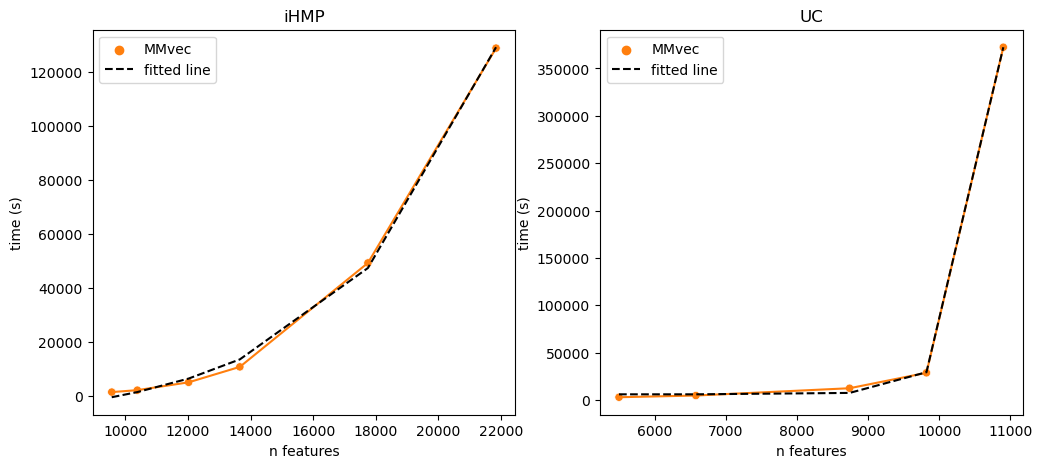

In [7]:
fig, axn = plt.subplots(1,2, figsize=(12,5))

ihmp_mmvec = ihmp_runtime[ihmp_runtime['method'] == 'MMvec']
uc_mmvec = uc_runtime[uc_runtime['method'] == 'MMvec']

xaxis = 'n features'

for ax_, df_, fit_, popt_, cohort_ in zip(axn.flatten(), 
                                          [ihmp_mmvec, uc_mmvec],
                                          [exp_curve_fit, exp_curve_fit],
                                          [popt_ihmp, popt_uc], ['iHMP', 'UC']):

    sns.scatterplot(ax=ax_, data=df_, x=xaxis, y='time (s)', 
                    hue='method', style='method', 
                    palette={'MMvec':'tab:orange'})
    ax_.plot(df_[xaxis], df_['time (s)'], 
            'tab:orange', label=None)
    ax_.plot(df_[xaxis], 
            fit_(df_[xaxis], *popt_), 'k--',
            label='fitted line')
    ax_.set_xlabel(xaxis)
    ax_.set_ylabel('time (s)')
    ax_.legend()
    ax_.set_title(cohort_)

plt.show()

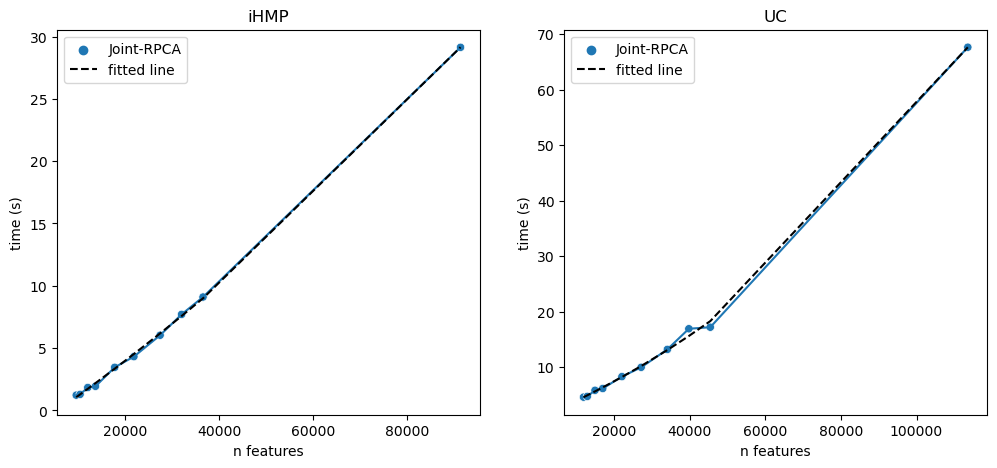

In [8]:
fig, axn = plt.subplots(1,2, figsize=(12,5))

ihmp_joint = ihmp_runtime[ihmp_runtime['method'] == 'Joint-RPCA']
uc_joint = uc_runtime[uc_runtime['method'] == 'Joint-RPCA']
xaxis = 'n features'

for ax_, df_, fit_, popt_, cohort_ in zip(axn.flatten(), 
                                         [ihmp_joint, uc_joint],
                                         [exp_curve_joint, exp_curve_joint],
                                         [joint_popt_ihmp, joint_popt_uc], 
                                         ['iHMP', 'UC']):

    sns.scatterplot(ax=ax_, data=df_, x=xaxis, y='time (s)', 
                    hue='method', style='method', 
                    palette={'Joint-RPCA':'tab:blue'})
    ax_.plot(df_[xaxis], df_['time (s)'], 
            'tab:blue', label=None)
    ax_.plot(df_[xaxis], 
            fit_(df_[xaxis], *popt_), 'k--',
            label='fitted line')
    ax_.set_xlabel(xaxis)
    ax_.set_ylabel('time (s)')
    ax_.legend()
    ax_.set_title(cohort_)

plt.show()

In [9]:
## estimate data points for MMvec-iHMP based on fitted curve
p_features = [30.0, 35.0, 40.0]
n_features = [int(0.01 * p * 91429.00) for p in p_features]
est_time = exp_curve_fit(np.array(n_features), *popt_ihmp)
#for the smaller datapoints, we will duplicate the first data point
p_features2 = [4.84, 5.79, 7.69, 8.65, 9.6]
n_features2 = [int(0.01 * p * 91429.00) for p in p_features2]
est_time2 = ihmp_runtime.loc[10, 'time (s)'] * np.ones(len(n_features2))

#create dataframe
mmvec_extra_df = pd.DataFrame({'method':'MMvec', 
                               'time (s)':list(est_time)+list(est_time2),
                               'n features':list(n_features)+list(n_features2), 
                               '% features':list(p_features)+list(p_features2)})
mmvec_extra_df

,method,time (s),n features,% features
0,MMvec,4.547914e+05,27428,30.00
1,MMvec,1.235524e+06,32000,35.00
2,MMvec,3.325559e+06,36571,40.00
3,MMvec,1.309905e+03,4425,4.84
4,MMvec,1.309905e+03,5293,5.79
5,MMvec,1.309905e+03,7030,7.69
6,MMvec,1.309905e+03,7908,8.65
7,MMvec,1.309905e+03,8777,9.60


In [10]:
#repeat for Joint-RPCA
#for the smaller datapoints, we will duplicate the first data point
#p_features and n_features are the same
est_time3 = ihmp_runtime.loc[0, 'time (s)'] * np.ones(len(n_features2))

#create dataframe
joint_extra_df = pd.DataFrame({'method':'Joint-RPCA', 
                               'time (s)':est_time3,
                               'n features':n_features2, 
                               '% features':p_features2})
joint_extra_df

,method,time (s),n features,% features
0,Joint-RPCA,1.223706,4425,4.84
1,Joint-RPCA,1.223706,5293,5.79
2,Joint-RPCA,1.223706,7030,7.69
3,Joint-RPCA,1.223706,7908,8.65
4,Joint-RPCA,1.223706,8777,9.60


In [11]:
ihmp_runtime_all = ihmp_runtime.copy()
ihmp_runtime_all = pd.concat([ihmp_runtime_all, mmvec_extra_df, joint_extra_df], ignore_index=True)
ihmp_runtime_all['time (hr)'] = ihmp_runtime_all['time (s)'] / 3600
ihmp_runtime_all.sort_values(by='n features', inplace=True)
#ihmp_runtime_all

In [12]:
#map unique % features to an index
p_features_map = {p:i for i, p in enumerate(p_features_all)}
ihmp_runtime_all['% features index'] = ihmp_runtime_all['% features'].map(p_features_map)
#ihmp_runtime_all

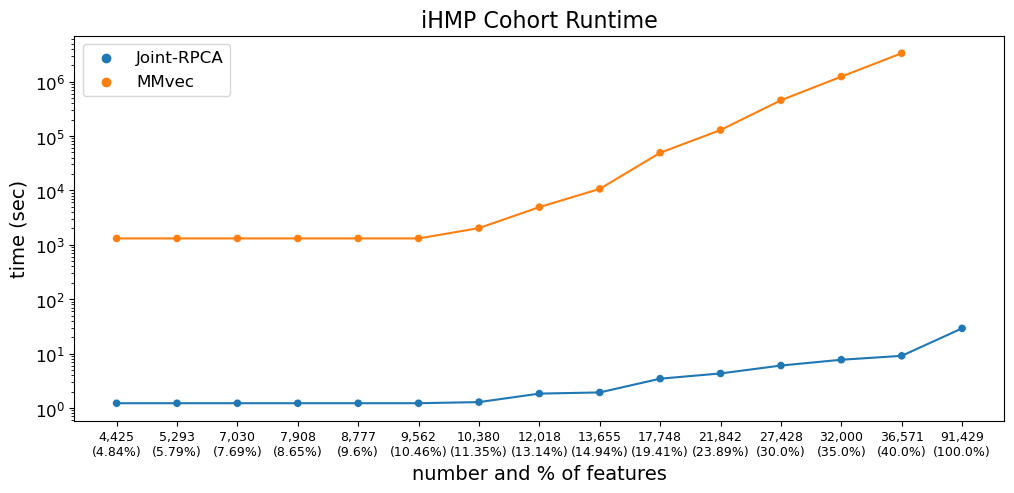

In [13]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=ihmp_runtime_all, x='% features index', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
sns.lineplot(data=ihmp_runtime_all, x='% features index', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
#log y axis
plt.yscale('log')
#increase font size
plt.ylabel('time (sec)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=12)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
all_n_features = sorted(list(ihmp_runtime_all['n features'].unique()))
x_labels = ['{:,}\n({}%)'.format(round(n), p) for p, n in zip(all_p_features, 
                                                              all_n_features)]
plt.xticks(list(range(0,len(all_p_features))), x_labels, fontsize=9)
plt.xlabel('number and % of features', fontsize=14)

#add second y axis with minutes instead of seconds
# plt.twinx()
# time_in_hr = [round(t / 3600, 1) for t in y_ticks]
# plt.yticks(y_ticks, labels=time_in_hr, fontsize=12)
# plt.ylabel('time (hr)', fontsize=14)
# plt.ylim(y_lim1)  # Match the y-axis limits

plt.title('iHMP Cohort Runtime', fontsize=16)
plt.show()

In [14]:
#repeat for uc
#for mmvec, add the extra data points
p_features_uc = [10.46, 11.35, 13.14]
n_features_uc = [int(0.01 * p * 113576.00) for p in p_features_uc]
est_time_uc = exp_curve_fit(np.array(n_features_uc), *popt_uc)
method_uc = ['MMvec'] * len(n_features_uc)
#for joint-rpca, add smaller data points
p_features3 = [4.84, 5.79, 7.69, 8.65, 9.6]
n_features3 = [int(0.01 * p * 91429.00) for p in p_features3]
est_time_joint = uc_runtime.loc[0, 'time (s)'] * np.ones(len(n_features3))
method_joint = ['Joint-RPCA'] * len(n_features3)
#create dataframe
extra_df_uc = pd.DataFrame({'method':method_uc+method_joint,
                            'time (s)':list(est_time_uc)+list(est_time_joint),
                            'n features':list(n_features_uc)+list(n_features3), 
                            '% features':list(p_features_uc)+list(p_features3)})

In [15]:
uc_runtime_all = uc_runtime.copy()
uc_runtime_all = pd.concat([uc_runtime_all, extra_df_uc], ignore_index=True)
uc_runtime_all['time (hr)'] = uc_runtime_all['time (s)'] / 3600
uc_runtime_all.sort_values(by='% features', inplace=True)
uc_runtime_all

,time (s),method,n features,% features,time (hr)
10,3.035739e+03,MMvec,5496.0,4.84,8.432610e-01
18,4.598135e+00,Joint-RPCA,4425.0,4.84,1.277260e-03
19,4.598135e+00,Joint-RPCA,5293.0,5.79,1.277260e-03
11,4.827727e+03,MMvec,6576.8,5.79,1.341035e+00
12,1.252373e+04,MMvec,8738.4,7.69,3.478814e+00
20,4.598135e+00,Joint-RPCA,7030.0,7.69,1.277260e-03
21,4.598135e+00,Joint-RPCA,7908.0,8.65,1.277260e-03
13,2.879375e+04,MMvec,9819.2,8.65,7.998264e+00
14,3.723500e+05,MMvec,10900.0,9.60,1.034306e+02
22,4.598135e+00,Joint-RPCA,8777.0,9.60,1.277260e-03


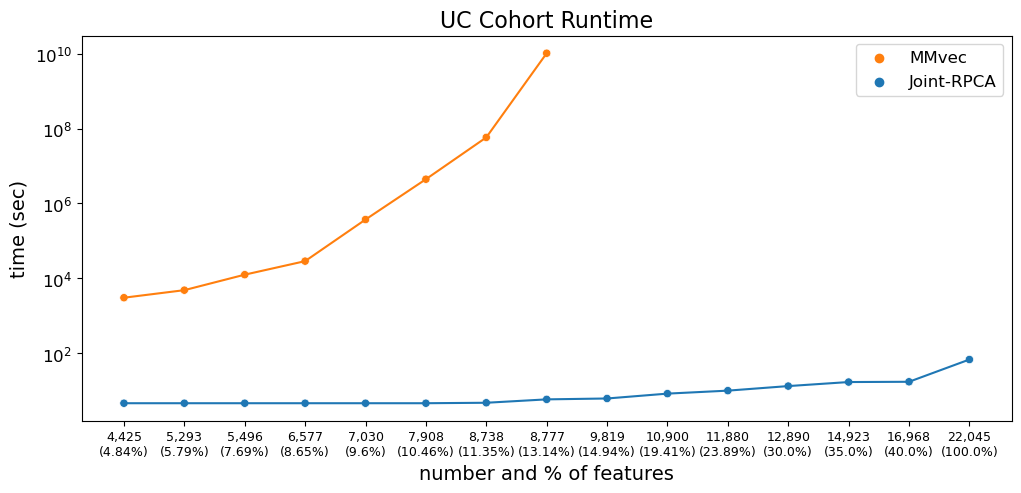

In [16]:
#map unique % features to an index
p_features_all = uc_runtime_all['% features'].astype(float).unique()
p_features_map = {p:i for i, p in enumerate(p_features_all)}
uc_runtime_all['% features index'] = uc_runtime_all['% features'].map(p_features_map)

#estimate additional runtimes for MMvec using runtime
plt.figure(figsize=(12,5))
sns.scatterplot(data=uc_runtime_all, x='% features index', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
sns.lineplot(data=uc_runtime_all, x='% features index', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
#log y axis
plt.yscale('log')
#increase font size
plt.ylabel('time (sec)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=12)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(uc_runtime_all['% features'].unique()))
all_n_features = sorted(list(uc_runtime_all['n features'].unique()))
x_labels = ['{:,}\n({}%)'.format(round(n), p) for p, n in zip(all_p_features, 
                                                              all_n_features)]
plt.xticks(list(range(0,len(all_p_features))), x_labels, fontsize=9)
plt.xlabel('number and % of features', fontsize=14)

#change xticks labels
#all_p_features = sorted(list(uc_runtime_all['% features'][:10]))
#all_n_features = sorted(list(uc_runtime_all['n features'][:10]))
#x_labels = ['{:,}\n({}%)'.format(round(n), p) for p, n in zip(all_p_features, 
#                                                              all_n_features)]
#plt.xticks(list(range(0,10)), x_labels, fontsize=10)
plt.xlabel('number and % of features', fontsize=14)
plt.title('UC Cohort Runtime', fontsize=16)

plt.show()

## Compare runtimes

In [17]:
#the dfs below are used for labeling a few datapoints (runtimes)
ihmp_joint = ihmp_runtime_all[ihmp_runtime_all['method'] == 'Joint-RPCA']
ihmp_mmvec = ihmp_runtime_all[ihmp_runtime_all['method'] == 'MMvec']
ihmp_joint.reset_index(drop=True, inplace=True)
ihmp_mmvec.reset_index(drop=True, inplace=True)

uc_joint = uc_runtime_all[uc_runtime_all['method'] == 'Joint-RPCA']
uc_mmvec = uc_runtime_all[uc_runtime_all['method'] == 'MMvec']
uc_joint.reset_index(drop=True, inplace=True)
uc_mmvec.reset_index(drop=True, inplace=True)

In [18]:
#more formatting
ihmp_runtime_all.reset_index(drop=True, inplace=True)
ihmp_runtime_all['method'] = ihmp_runtime_all['method'].astype('str')
ihmp_runtime_all['method_detailed'] = ihmp_runtime_all['method'].copy()

uc_runtime_all.reset_index(drop=True, inplace=True)
uc_runtime_all['method'] = uc_runtime_all['method'].astype('str')
uc_runtime_all['method_detailed'] = uc_runtime_all['method'].copy()

#note which values are estimated
#joint-RCPA
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method'] == 'Joint-RPCA') & (ihmp_runtime_all['% features'] < 10),
                                               'joint_estimated', ihmp_runtime_all['method_detailed'])
uc_runtime_all['method_detailed'] = np.where((uc_runtime_all['method'] == 'Joint-RPCA') & (uc_runtime_all['% features'] < 10),
                                               'joint_estimated', uc_runtime_all['method_detailed'])
#MMvec iHMP
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method'] == 'MMvec') & (ihmp_runtime_all['% features'] < 10),
                                               'mmvec_estimated1', ihmp_runtime_all['method_detailed'])
ihmp_runtime_all['method_detailed'] = np.where((ihmp_runtime_all['method'] == 'MMvec') & (ihmp_runtime_all['% features'] > 24),
                                               'mmvec_estimated2', ihmp_runtime_all['method_detailed'])
#MMvec UC
uc_runtime_all['method_detailed'] = np.where((uc_runtime_all['method'] == 'MMvec') & (uc_runtime_all['% features'] > 10),
                                              'mmvec_estimated', uc_runtime_all['method_detailed'])

In [19]:
#create small df to connect lines between hues
ihmp_runtime_all_small = ihmp_runtime_all[(ihmp_runtime_all['% features'] > 9) & (ihmp_runtime_all['% features'] < 11)]
ihmp_runtime_all_small2 = ihmp_runtime_all[(ihmp_runtime_all['% features'] > 23) & (ihmp_runtime_all['% features'] < 31) & 
                                                                                  (ihmp_runtime_all['method'] == 'MMvec')]
uc_runtime_all_small = uc_runtime_all[(uc_runtime_all['% features'] > 9) & (uc_runtime_all['% features'] < 11)]

In [20]:
#add one to % of features index -- useful later for plotting
for df in [ihmp_runtime_all_small, ihmp_runtime_all_small2, 
           uc_runtime_all_small, ihmp_runtime_all, uc_runtime_all]:
    df['% features index'] = df['% features index'] + 1

#add one to % of features index -- useful later for plotting
for df in [ihmp_joint, ihmp_mmvec, uc_joint, uc_mmvec]:
    df.index = df.index + 1

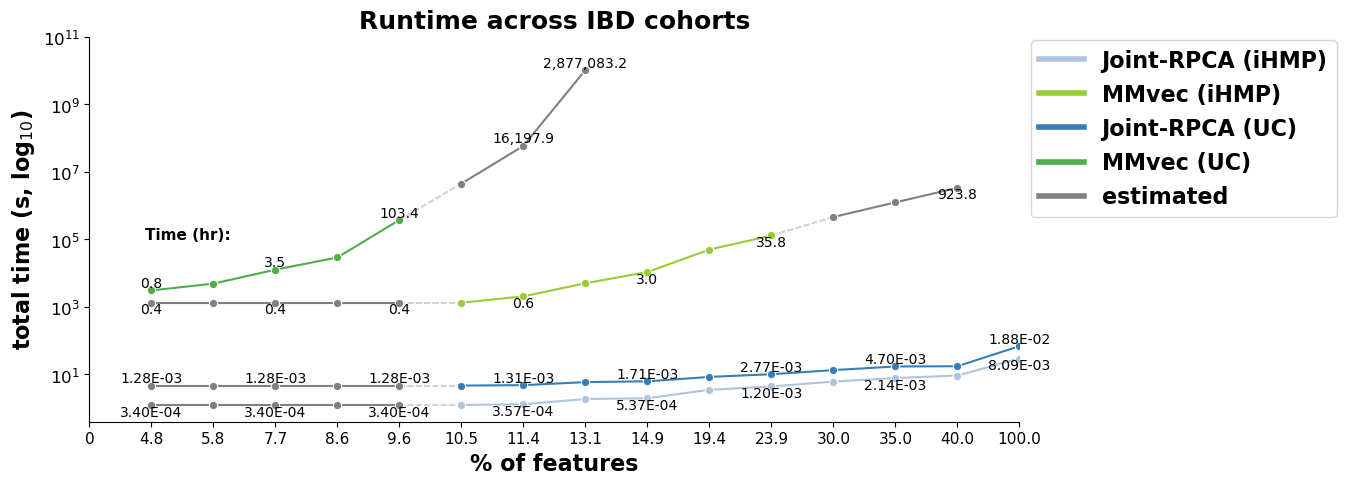

In [27]:
#estimate additional runtimes for MMvec using runtime
fig = plt.figure(figsize=(12,5))
ihmp_palette = {'Joint-RPCA':'lightsteelblue', 'MMvec':'yellowgreen', 
                'joint_estimated':'gray', 'mmvec_estimated1':'gray',
                 'mmvec_estimated2':'gray'}
uc_palette = {'Joint-RPCA':'#377eb8', 'MMvec':'#4daf4a',
              'joint_estimated':'gray', 'mmvec_estimated':'gray'}

#plot separate lines to connect between hues
ax1 = sns.lineplot(data=ihmp_runtime_all_small, x='% features index', y='time (s)', 
                   hue='method', palette={'Joint-RPCA':'lightgray', 'MMvec':'lightgray'},
                   style='method', dashes=[(3,1)])
ax1.legend_.remove()

ax2 = sns.lineplot(data=ihmp_runtime_all_small2, x='% features index', y='time (s)', 
                   hue='method', palette={'Joint-RPCA':'lightgray', 'MMvec':'lightgray'},
                   style='method', dashes=[(3,1)])
ax2.legend_.remove()

ax3 = sns.lineplot(data=uc_runtime_all_small, x='% features index', y='time (s)', 
                   hue='method', palette={'Joint-RPCA':'lightgray', 'MMvec':'lightgray'},
                   style='method', dashes=[(3,1)])
ax3.legend_.remove()

#plot lines with hues added
ax4 = sns.lineplot(data=ihmp_runtime_all, x='% features index', y='time (s)', 
                    hue='method_detailed', 
                    hue_order=['Joint-RPCA','MMvec','joint_estimated','mmvec_estimated1','mmvec_estimated2'], 
                    palette=ihmp_palette, marker="o")

ax5 = sns.lineplot(data=uc_runtime_all, x='% features index', y='time (s)', 
                    hue='method_detailed',
                    hue_order=['Joint-RPCA','MMvec','joint_estimated','mmvec_estimated'], 
                    palette=uc_palette, marker="o")
#log y axis
plt.yscale('log')
plt.ylim([0.0, 1e11])
#increase font size
plt.ylabel('total time (s, log$_{10}$)', fontsize=16, weight='bold')
plt.yticks(fontsize=12)

#keep only half of the legend
handles, _ = plt.gca().get_legend_handles_labels()
handles = handles[5:]
handles_keep = np.concatenate([handles[0:2], handles[5:8]])
labels = ['Joint-RPCA (iHMP)', 'MMvec (iHMP)', 
          'Joint-RPCA (UC)', 'MMvec (UC)', 'estimated']
legend = plt.legend(handles_keep, labels, fontsize=14,
                    prop={'size':16, 'weight':'bold'}, ncol=1,
                    bbox_to_anchor=(1, 1.02),
                    fancybox=True)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
all_p_features = [round(p, 1) for p in all_p_features]
all_p_features_plot = [0] + list(all_p_features)

plt.xticks(list(range(0, len(all_p_features_plot))), all_p_features_plot, fontsize=11)
plt.xlim([0, len(all_p_features_plot)-1])
plt.xlabel('% of features', fontsize=16, weight='bold')

#add text to every other point to show the time in seconds
plt.text(0.9, 1e5, "Time (hr):", ha='left', fontsize=11, fontweight='semibold')
for i, p in enumerate(all_p_features):
    j = i + 1
    if i % 2 == 0 or j == 15:
        #joint-rpca
        y_ihmp_joint = ihmp_joint.loc[j, 'time (s)']
        txt_ihmp_joint = '%.2E' % Decimal(y_ihmp_joint/3600)
        plt.text(j, y_ihmp_joint, txt_ihmp_joint, 
                 fontsize=10, ha='center', va='top',)
        
        y_uc_joint = uc_joint.loc[j, 'time (s)']
        txt_uc_joint = '%.2E' % Decimal(y_uc_joint/3600)
        plt.text(j, y_uc_joint, txt_uc_joint, 
                 fontsize=10, ha='center', va='bottom',)
    
    if (i % 2 == 0 and j <= 7) or j==8:
        #mmvec
        y_uc_mmvec = uc_mmvec.loc[j, 'time (s)']
        txt_uc_mmvec = round(y_uc_mmvec/3600, 1)
        txt_uc_mmvec = '{:,}'.format(txt_uc_mmvec)
        plt.text(j, y_uc_mmvec, txt_uc_mmvec, 
                 fontsize=10, ha='center', va='bottom',)
    
    if (i % 2 == 0 and j < 12) or j==14:
        #mmvec
        y_ihmp_mmvec = ihmp_mmvec.loc[j, 'time (s)']
        txt_ihmp_mmvec = round(y_ihmp_mmvec/3600, 1)
        plt.text(j, y_ihmp_mmvec, txt_ihmp_mmvec, 
                 fontsize=10, ha='center', va='top',)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

plt.title('Runtime across IBD cohorts', fontsize=18, weight='bold')
plt.savefig('../figures/runtime-features-comparison.png', 
           dpi=1000, bbox_inches='tight',
           facecolor=fig.get_facecolor())
plt.show()